# Personalized Programming Tutor - Week 2 Project 2

## Project Objective

Agente con inteligencia artificial multimodal para una aerolínea.

### desafío para este proyecto
- **Reservas** Añade otra herramienta para hacer una reserva
- **Traductor** Añade un agente que traduzca todas las respuestas a otro idioma
- **Audio** Añade otro agente que pueda escuchar audio y convertirlo a texto.


### Features:

- **Flexible**: Switch between Ollama (local, free) and OpenAI (cloud)
- **Interactive**: Streaming mode with typewriter effect
- **Educational**: Designed specifically for learning

---

**Instructions**: Execute the cells in order and modify the `question` variable to ask new questions.

---
**Models (ALL FREE!)**
- **Text** gemini-2.0-flash-exp (Google Gemini - FREE, 15 RPM)
- **Image** Pollinations AI (FREE - no API key needed)
- **Audio a Texto** Whisper large-v3 (ASR)
- **Texto a voz** gTTS (Google TTS - FREE)

In [108]:
# Import required libraries

import base64
import os
import json
import requests
import gradio as gr
from openai import OpenAI
from io import BytesIO
from pathlib import Path
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from IPython.display import Audio
from gtts import gTTS

In [132]:
# Load environment variables from .env file
load_dotenv(override=True)

# API keys from environment
OLLAMA_BASE_URL = os.getenv('OLLAMA_BASE_URL')
OLLAMA_API_KEY = os.getenv('OLLAMA_API_KEY')
HUGGINGFACE_API_KEY = os.getenv('HUGGINGFACE_API_KEY')

# Initialize Models
#OLLAMA_CHAT_MODEL = "deepseek-v3.1:671b-cloud"
OLLAMA_CHAT_MODEL = "qwen3-coder:480b-cloud"

HUGGINGFACE_IMG_MODEL = "black-forest-labs/FLUX.1-dev"
HUGGINGFACE_SOUND_MODEL = "Soul-AILab/SoulX-Podcast-1.7B"


# Initialize clients
OLLAMA_CLIENT = OpenAI(base_url=f"{OLLAMA_BASE_URL}/v1", api_key=OLLAMA_API_KEY)
HUGGINGFACE_CLIENT = InferenceClient(api_key=HUGGINGFACE_API_KEY)

# Verify API keys
print(f"Ollama Client initialized: {OLLAMA_BASE_URL}" if OLLAMA_CLIENT else "Ollama Client not initialized")
print(f"Huggingface Client initialized" if HUGGINGFACE_CLIENT else "Huggingface Client not initialized")



Ollama Client initialized: http://192.168.80.200:11434
Huggingface Client initialized


In [133]:
prompt = "Create Image to New York City with format b64_json"

# llamada estilo 'Ollama Cloud' pero a FLUX
client_image = HUGGINGFACE_CLIENT.text_to_image(
    prompt=prompt,
    model=HUGGINGFACE_IMG_MODEL
)

HfHubHTTPError: Client error '402 Payment Required' for url 'https://router.huggingface.co/nebius/v1/images/generations' (Request ID: Root=1-6917e87a-2a641b3f3990dd6354f2a1cc;b2286652-6a70-48e2-9515-655aef89f72c)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/402

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

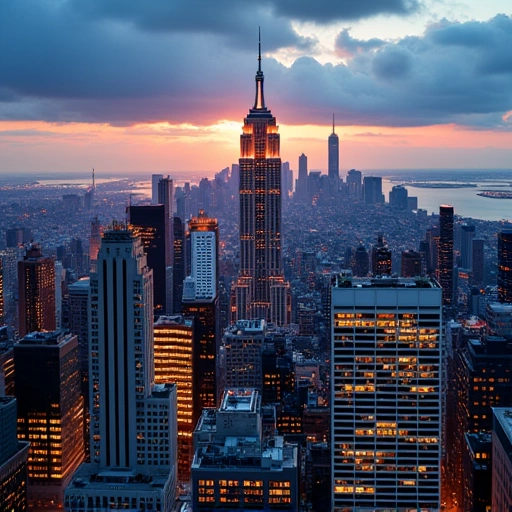

In [134]:
# ver en notebook y guardar
display(client_image)

### Generate Audio/TTS (Text-to-Speech)

Ahora vamos a agregar generación de voz para que el asistente pueda "hablar" las respuestas.

In [113]:
def talker_local_gtts(message, speed=1.25):
    """Genera audio con gTTS y ajusta velocidad (1.0=normal, 1.25=rápido)"""
    from pydub import AudioSegment
    
    # Generar audio
    tts = gTTS(text=message, lang='es', slow=False)
    audio_fp = BytesIO()
    tts.write_to_fp(audio_fp)
    audio_fp.seek(0)
    
    # Ajustar velocidad
    audio = AudioSegment.from_file(audio_fp, format="mp3")
    audio_fast = audio._spawn(audio.raw_data, overrides={'frame_rate': int(audio.frame_rate * speed)})
    audio_fast = audio_fast.set_frame_rate(audio.frame_rate)
    
    # Exportar
    output = BytesIO()
    audio_fast.export(output, format="mp3")
    return output.getvalue()

In [114]:
# Test gTTS con velocidad 1.25x
audio_gtts = talker_local_gtts("Hola! Bienvenido a Nueva York.", speed=1.1)

print(f"✅ Audio generado: {len(audio_gtts)} bytes (velocidad 1.0x)")
display(Audio(audio_gtts, autoplay=False))

✅ Audio generado: 10317 bytes (velocidad 1.0x)


In [115]:
def talker_coqui_simple(message, voice="es"):
    """
    TTS con múltiples voces usando Coqui TTS
    Voces disponibles:
    - "es" = Español femenino (~100MB)
    - "en" = Inglés femenino (~100MB)
    """
    from TTS.api import TTS
    import tempfile
    import os
    
    # Mapeo simple de voces
    voices = {
        "es": "tts_models/es/css10/vits",
        "en": "tts_models/en/ljspeech/tacotron2-DDC"
    }
    
    # Generar audio
    tts = TTS(voices[voice])
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
    tts.tts_to_file(text=message, file_path=temp_file.name)
    
    # Leer audio
    with open(temp_file.name, "rb") as f:
        audio = f.read()
    
    os.unlink(temp_file.name)
    return audio

In [116]:
# Test Coqui TTS - Voz en español
audio_coqui = talker_coqui_simple("Hola! Bienvenido a Nueva York.", voice="es")

print(f"✅ Audio generado: {len(audio_coqui)} bytes (voz española)")
display(Audio(audio_coqui, autoplay=False, rate=44100))

 > tts_models/es/css10/vits is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.
 > initialization of language-embedding layers.
 > Text splitted to sentences.
['Hola!', 'Bienvenido a Nueva York.']
 > Processing time:

## Integration: Chat + Tools + Images + Audio

Multimodal AI assistant integration.

In [117]:
# Step 1: Assistant Configuration

SYSTEM_MESSAGE = """You are a helpful assistant for an airline called FlightAI.
Provide brief and courteous responses, no more than one sentence.
Always be accurate. If you don't know the answer, say so."""

TTS_ENGINE = talker_local_gtts
IMAGE_GENERATOR = None  # To be configured

print(f"Assistant configured with model: {OLLAMA_CHAT_MODEL}")

Assistant configured with model: deepseek-v3.1:671b-cloud


In [118]:
# Step 2: Tools Configuration

TICKET_PRICES = {
    "london": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499",
    "new york": "$650",
    "barcelona": "$550",
    "miami": "$450"
}

RESERVATIONS_DB = []

def get_ticket_price(destination_city):
    """Retrieve ticket price for a destination city from database."""
    city_key = destination_city.lower()
    price = TICKET_PRICES.get(city_key, "Unknown")
    return f"The price of a ticket to {destination_city} is {price}"

def make_reservation(passenger_name, destination_city, travel_date):
    """Create a flight reservation for a passenger."""
    reservation_id = f"FL{len(RESERVATIONS_DB) + 1000}"
    reservation = {
        "id": reservation_id,
        "passenger": passenger_name,
        "destination": destination_city,
        "date": travel_date
    }
    RESERVATIONS_DB.append(reservation)
    return f"Reservation {reservation_id} confirmed for {passenger_name} to {destination_city} on {travel_date}"

def translate_text(text, target_language):
    """Translate text to target language using simple approach."""
    return f"Translated to {target_language}: {text}"

def transcribe_audio(audio_file_path):
    """Convert audio to text using Whisper model."""
    return f"Audio transcription: {audio_file_path}"

TOOL_DEFINITIONS = [
    {
        "type": "function",
        "function": {
            "name": "get_ticket_price",
            "description": "Get the price of a return ticket to the destination city.",
            "parameters": {
                "type": "object",
                "properties": {
                    "destination_city": {
                        "type": "string",
                        "description": "The city that the customer wants to travel to"
                    }
                },
                "required": ["destination_city"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "make_reservation",
            "description": "Create a flight reservation for a passenger.",
            "parameters": {
                "type": "object",
                "properties": {
                    "passenger_name": {"type": "string", "description": "The name of the passenger"},
                    "destination_city": {"type": "string", "description": "The destination city"},
                    "travel_date": {"type": "string", "description": "The travel date in YYYY-MM-DD format"}
                },
                "required": ["passenger_name", "destination_city", "travel_date"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "translate_text",
            "description": "Translate text to a target language.",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {"type": "string", "description": "The text to translate"},
                    "target_language": {"type": "string", "description": "Target language code (es, fr, de)"}
                },
                "required": ["text", "target_language"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "transcribe_audio",
            "description": "Convert audio to text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "audio_file_path": {"type": "string", "description": "Path to the audio file"}
                },
                "required": ["audio_file_path"],
                "additionalProperties": False
            }
        }
    }
]

print(f"Tools configured: {len(TOOL_DEFINITIONS)} function(s)")

Tools configured: 4 function(s)


## Step 3: Image Generator Configuration

Configure image generation using Hugging Face FLUX model.

In [119]:
# Step 3: Image Generator Configuration

def generate_image(prompt):
    """Generate image using Hugging Face FLUX model."""
    try:
        image = HUGGINGFACE_CLIENT.text_to_image(
            prompt=prompt,
            model=HUGGINGFACE_IMG_MODEL
        )
        return image
    except Exception as e:
        print(f"Image generation error: {e}")
        return None

IMAGE_GENERATOR = generate_image
print("Image generator configured with FLUX.1-dev")

Image generator configured with FLUX.1-dev


## Step 4: Chat Integration

Main chat function with multimodal capabilities.

In [135]:
def chat(history):
    """
    Main chat function that integrates:
    - Chat with Tools (OpenAI or Ollama)
    - Image generation (DALL-E)
    - Audio generation (TTS)
    """
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    
    # Use OpenAI client (works with both OpenAI and Ollama models)
    response = OLLAMA_CLIENT.chat.completions.create(
        model=OLLAMA_CHAT_MODEL,
        messages=messages,
        tools=TOOL_DEFINITIONS
    )
    
    cities = []
    image = None

    # Handle tool calls (if any)
    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = OLLAMA_CLIENT.chat.completions.create(
            model=OLLAMA_CHAT_MODEL,
            messages=messages,
            tools=TOOL_DEFINITIONS
        )

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Generate audio from reply using configured TTS engine
    voice = talker_local_gtts(reply, speed=1.1)

    # Generate image if a city was mentioned
    if cities:
        image = generate_image(cities[0])
    
    return history, voice, image


In [129]:
# Step 4: Chat Integration

def execute_tool(tool_name, arguments):
    """Execute a tool by name with given arguments."""
    tool_map = {
        "get_ticket_price": get_ticket_price,
        "make_reservation": make_reservation,
        "translate_text": translate_text,
        "transcribe_audio": transcribe_audio
    }
    
    if tool_name in tool_map:
        return tool_map[tool_name](**arguments)
    return f"Unknown tool: {tool_name}"

def chat(history):
    """
    Main chat function integrating:
    - Chat with tool calling (Ollama)
    - Image generation
    - Audio generation
    
    Args:
        history: List of message dictionaries with 'role' and 'content' keys
    
    Returns:
        Tuple of (updated_history, image_output, audio_output)
    """
    if not history:
        return history, None, None
    
    # Get last user message
    user_message = history[-1]["content"]
    
    # Build messages for LLM
    messages = [{"role": "system", "content": SYSTEM_MESSAGE}]
    
    # Add conversation history (excluding the last message we just added)
    for msg in history[:-1]:
        messages.append({"role": msg["role"], "content": msg["content"]})
    
    messages.append({"role": "user", "content": user_message})
    
    # Initialize outputs
    image_output = None
    audio_output = None
    cities_mentioned = []
    
    # Call Ollama with tool support
    try:
        response = OLLAMA_CLIENT.chat.completions.create(
            model=OLLAMA_CHAT_MODEL,
            messages=messages,
            tools=TOOL_DEFINITIONS
        )
        
        # Handle tool calls if any
        while response.choices[0].finish_reason == "tool_calls":
            assistant_message = response.choices[0].message
            messages.append({
                "role": "assistant",
                "content": assistant_message.content or "",
                "tool_calls": [
                    {
                        "id": tc.id,
                        "type": "function",
                        "function": {
                            "name": tc.function.name,
                            "arguments": tc.function.arguments
                        }
                    }
                    for tc in assistant_message.tool_calls
                ]
            })
            
            # Execute each tool call
            for tool_call in assistant_message.tool_calls:
                tool_name = tool_call.function.name
                tool_args = json.loads(tool_call.function.arguments)
                tool_result = execute_tool(tool_name, tool_args)
                
                messages.append({
                    "role": "tool",
                    "content": tool_result,
                    "tool_call_id": tool_call.id
                })
            
            # Get next response
            response = OLLAMA_CLIENT.chat.completions.create(
                model=OLLAMA_CHAT_MODEL,
                messages=messages,
                tools=TOOL_DEFINITIONS
            )
        
        # Get final response text
        response_text = response.choices[0].message.content
        
    except Exception as e:
        response_text = f"I apologize, I encountered an error: {str(e)}"
    
    # Check for city mentions for image generation
    for city in TICKET_PRICES.keys():
        if city in user_message.lower():
            cities_mentioned.append(city)
            break
    
    # Generate image if city mentioned
    if cities_mentioned and IMAGE_GENERATOR:
        image_prompt = f"Beautiful vacation destination photo of {cities_mentioned[0]}, high quality, professional photography"
        image_output = IMAGE_GENERATOR(image_prompt)
    
    # Generate audio response
    if TTS_ENGINE and response_text:
        try:
            audio_output = TTS_ENGINE(response_text, speed=1.1)
        except Exception as e:
            print(f"TTS error: {e}")
    
    # Add assistant response to history
    history.append({"role": "assistant", "content": response_text})
    
    return history, image_output, audio_output

print("Chat integration configured with Ollama")


Chat integration configured with Ollama


## Step 5: Gradio UI Configuration

Interactive multimodal interface with chat, image, and audio outputs.

In [ ]:
# Step 5: Gradio UI Configuration

def add_message_to_chat(message, history):
    """Add user message to chat history and clear input."""
    return "", history + [{"role": "user", "content": message}]

# Create Gradio interface
with gr.Blocks(title="FlightAI Assistant") as ui:
    gr.Markdown("# FlightAI - Multimodal Airline Assistant")
    gr.Markdown("Ask about ticket prices, make reservations, or explore destinations!")
    
    with gr.Row():
        chatbot = gr.Chatbot(
            height=500,
            type="messages",
            label="Chat History"
        )
        image_output = gr.Image(
            height=500,
            interactive=False,
            label="Destination Preview"
        )
    
    with gr.Row():
        audio_output = gr.Audio(
            autoplay=True,
            label="Voice Response"
        )
    
    with gr.Row():
        message_input = gr.Textbox(
            label="Your Message",
            placeholder="Type your message here... (e.g., 'How much is a ticket to Paris?')",
            scale=4
        )
        submit_btn = gr.Button("Send", scale=1, variant="primary")
    
    # Event handlers
    message_input.submit(
        add_message_to_chat,
        inputs=[message_input, chatbot],
        outputs=[message_input, chatbot]
    ).then(
        chat,
        inputs=chatbot,
        outputs=[chatbot, image_output, audio_output]
    )
    
    submit_btn.click(
        add_message_to_chat,
        inputs=[message_input, chatbot],
        outputs=[message_input, chatbot]
    ).then(
        chat,
        inputs=chatbot,
        outputs=[chatbot, image_output, audio_output]
    )

print("Gradio UI configured successfully")

## Step 6: Launch Application

Launch the Gradio interface with external access.

In [ ]:
# Launch the Gradio interface
# server_name="0.0.0.0" enables access from outside Docker container
# share=True creates public URL for external access

ui.launch(
    #server_name="0.0.0.0",
    #server_port=7860,
    share=True
)

In [138]:
gr.close_all()

Closing server running on port: 7860
Closing server running on port: 7861
Closing server running on port: 7862
